Installs Firedrake in the current Google Colab runtime if it's not already installed:

In [2]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-10-01 15:04:30--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-10-01 15:04:30 (50.0 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9732

In addition to importing firedrake as usual, we will need to construct the correct quadrature rules for the mass-lumping by hand. FInAT is responsible for providing these quadrature rules, so we import it here too.:

In [3]:
from firedrake import *
import finat

import math

A simple uniform triangular mesh is created:

In [4]:
mesh = RectangleMesh(100, 100, 5.0, 5.0)

We choose a degree 2 KMV continuous function space, set it up and then create some functions used in time-stepping:

In [5]:
V = FunctionSpace(mesh, "KMV", 2)

u = TrialFunction(V)
v = TestFunction(V)

u_np1 = Function(V)  # timestep n+1
u_n = Function(V)    # timestep n
u_nm1 = Function(V)  # timestep n-1

Now we set the time-stepping variables performing a simulation for 1 second with a timestep of 0.001 seconds:

In [6]:
T = 1.0
dt = 0.001
t = 0
step = 0

Unmount any previous Google Drive mount and remount it at /content/drive with reauthentication, ensuring a clean mount point:

In [7]:
!fusermount -u /content/drive 2>/dev/null || true
!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Sets the Drive root in Colab, defines the output path, and creates the folder (and parent folders) if it doesn’t already exist:

In [8]:
root = "/content/drive/MyDrive/"
outdir = root + "/Colab Notebooks/scalar_wave_equation_larger_domain-out"
import os; os.makedirs(outdir, exist_ok=True)

Creates a VTK (.pvd) file in outdir and writes the field u_n at time t for visualization:

In [9]:
from firedrake import VTKFile
outfile = VTKFile(outdir + "/scalar_wave_equation_larger_domain-out.pvd")
#outfile.write(u_n, time=t)

Ricker wavelets are often used to excite the domain in seismology. They have one free parameter: a peak frequency peak.
.

Here we inject a Ricker wavelet into the domain with a frequency of 6 Hz. For simplicity, we set the seismic velocity in the domain to be a constant:

In [10]:
freq = 6
c = Constant(1.5)

The following two functions are used to inject the Ricker wavelet source into the domain. We create a time-varying function to model the time evolution of the Ricker wavelet, given by the equation below and illustrated in Figure 1:

$f(t) = [1 - 2 (\pi f_p t)^2] e^{-(\pi f_p t)^2}$


**Figure 1 - Ricker Wavelet**
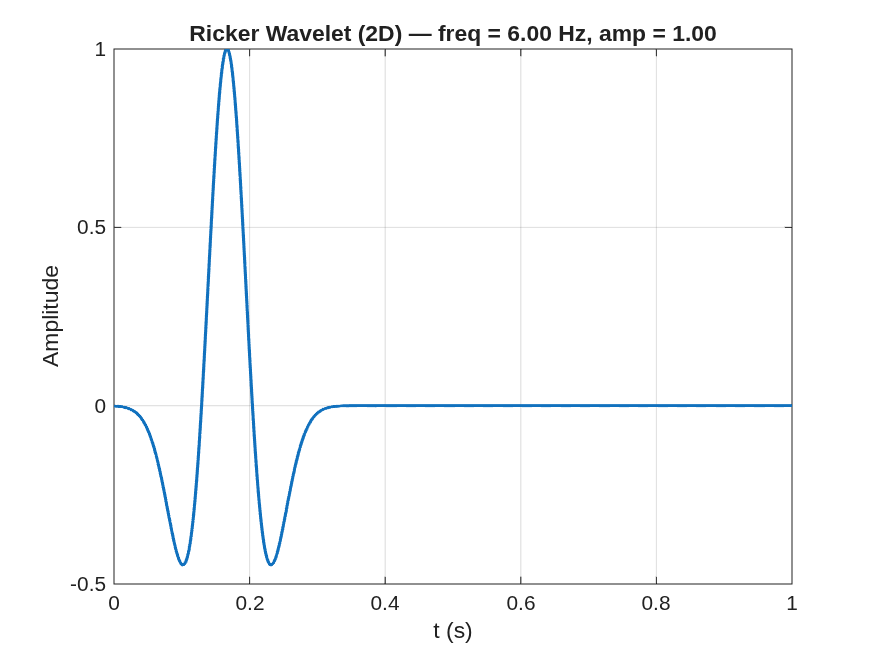

In [11]:
def RickerWavelet(t, freq, amp=1.0):
    # Shift in time so the entire wavelet is injected
    t_shifted = t - 1.0 / freq  # Time shift to center the wavelet

    factor = 1 - 2 * math.pi**2 * (freq**2) * (t_shifted**2)
    envelope = math.exp(-math.pi**2 * (freq**2) * (t_shifted**2))

    return amp * factor * envelope

The spatial distribution of the source function is a Guassian kernel with a standard deviation of 2,000 so that it’s sufficiently localized to emulate a Dirac delta function:

In [12]:
def delta_expr(x0, x, y, sigma_x=2000.0):
    sigma_x = Constant(sigma_x)
    return exp(-sigma_x * ((x - x0[0]) ** 2 + (y - x0[1]) ** 2))

To assemble the diagonal mass matrix, we need to create the matching colocated quadrature rule. FInAT implements custom "KMV" quadrature rules to do this. We obtain the appropriate cell from the function space, along with the degree of the element and construct the quadrature rule:

In [13]:
quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")

Then we make a new Measure object that uses this rule:

In [14]:
dxlump=dx(scheme=quad_rule)

Using Firedrake, we specify the mass matrix using the special quadrature rule with the Measure object we created above like so:

In [15]:
m = (u - 2.0 * u_n + u_nm1) / Constant(dt * dt) * v * dxlump

The stiffness matrix $a(u,v)$ is formed using a standard quadrature rule and is treated explicitly:

In [16]:
a = c*c*dot(grad(u_n), grad(v)) * dx

The source is injected at the center of the unit square:

In [17]:
x, y = SpatialCoordinate(mesh)
source = Constant([2.5, 4.5])
ricker = Constant(0.0)
ricker.assign(RickerWavelet(t, freq))

Constant([-0.00096925], name='constant_3', count=3)

We also create a cofunction R to save the assembled RHS vector:

In [18]:
R = Cofunction(V.dual())

Finally, we define the whole variational form $F$, assemble it, and then create a cached PETSc LinearSolver object to efficiently timestep with:

In [19]:
F = m + a -  delta_expr(source, x, y)*ricker * v * dx
a, r = lhs(F), rhs(F)
A = assemble(a)
solver = LinearSolver(A, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})

/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(


Now we are ready to start the time-stepping loop:

In [20]:
step = 0
while t < T:
    step += 1

    # Update the RHS vector according to the current simulation time `t`

    ricker.assign(RickerWavelet(t, freq))

    R = assemble(r, tensor=R)

    # Call the solver object to do point-wise division to solve the system.

    solver.solve(u_np1, R)

    # Exchange the solution at the two time-stepping levels.

    u_nm1.assign(u_n)
    u_n.assign(u_np1)

    # Increment the time and write the solution to the file for visualization in ParaView.

    t += dt
    if step % 10 == 0:
        print("Elapsed time is: "+str(t))
        outfile.write(u_n, time=t)

/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(


Elapsed time is: 0.010000000000000002
Elapsed time is: 0.02000000000000001
Elapsed time is: 0.03000000000000002
Elapsed time is: 0.04000000000000003
Elapsed time is: 0.05000000000000004
Elapsed time is: 0.060000000000000046
Elapsed time is: 0.07000000000000005
Elapsed time is: 0.08000000000000006
Elapsed time is: 0.09000000000000007
Elapsed time is: 0.10000000000000007
Elapsed time is: 0.11000000000000008
Elapsed time is: 0.12000000000000009
Elapsed time is: 0.1300000000000001
Elapsed time is: 0.1400000000000001
Elapsed time is: 0.1500000000000001
Elapsed time is: 0.16000000000000011
Elapsed time is: 0.17000000000000012
Elapsed time is: 0.18000000000000013
Elapsed time is: 0.19000000000000014
Elapsed time is: 0.20000000000000015
Elapsed time is: 0.21000000000000016
Elapsed time is: 0.22000000000000017
Elapsed time is: 0.23000000000000018
Elapsed time is: 0.24000000000000019
Elapsed time is: 0.25000000000000017
Elapsed time is: 0.2600000000000002
Elapsed time is: 0.2700000000000002
Elap